# Factorial Analysis

In [1]:
#install.packages("stringi")
#install.packages("ggplot2")
#install.packages("readxl")

library(readxl)
library(stringi)
library(ggplot2)

## Import Presidential Elections results

In [2]:
results_2016 <- read_excel("../input/2016_Election_Results.xlsx", 1)
results_2016['State_Winner_2016'] <- ifelse(results_2016['Trump pct']>results_2016['Clinton pct'], "Trump", "Clinton")
results_2016 <- results_2016[,c('State', 'State_Winner_2016')]

results_2008 <- read_excel("../input/2008_Election_Results.xlsx", 1)
results_2008['State_Winner_2008'] <- ifelse(results_2008['McCain pct']>results_2008['Obama pct'], "McCain", "Obama")
results_2008 <- results_2008[,c('State', 'State_Winner_2008')]

Warning message in strptime(x, format, tz = tz):
“unknown timezone 'zone/tz/2018c.1.0/zoneinfo/America/Toronto'”

## Functions

In [54]:
data_formatting <- function(year){
    
    congress_num <- floor((year-1787)/2)
    session <- (year+1)%%2 + 1
    
    senate_votes <- read.csv(paste("../input/Senate_Votes_", congress_num, "_", session, ".csv", sep = ""))
    nb_votes = dim(senate_votes)[2]-3
    sen_info = senate_votes[,c(1:3)]
    votes = senate_votes[,c(1, 4:dim(senate_votes)[2])]
    
    sen_info <- merge(sen_info, results_2016, by.x = "Senator_State", by.y = "State", all.x=TRUE)
    sen_info <- merge(sen_info, results_2008, by.x = "Senator_State", by.y = "State", all.x=TRUE)
    sen_info = sen_info[, c('Senator_Name','Senator_Party','Senator_State','State_Winner_2016', 'State_Winner_2008')]
    
    info_vars = dim(sen_info)[2]
    data = merge(sen_info, votes, by = "Senator_Name", all = TRUE)
    
    #Exclude short term senators 
    data = data[rowSums(abs(data[, c((info_vars+1):dim(senate_votes)[2])])) > 0.8*nb_votes,]
    
    #Restrict to active/projected variables
    sen_info <- data[,c(1:info_vars)]
    data.active <- data[,-c(1:info_vars)]
    
    return(list(sen_info, data.active))
}

In [55]:
pca <- function(sen_info, data.active){

    #Scale the matrix
    data.scaled.indv <- data.active

    #We create the correlation matrix
    data.correl.indv <- (1/length(data.active[,1]))*
                            t(data.scaled.indv)%*%as.matrix(data.scaled.indv)

    #Eigen-values and vectors
    data.eig.indv <- eigen(data.correl.indv)
    eigenvalues.indv <- as.data.frame(data.eig.indv$values / sum(data.eig.indv$values))
    eigenvectors.indv <- as.data.frame(data.eig.indv$vectors)

    numberDimension <- 5
    axes <- matrix(nrow=numberDimension, ncol=1)
    for (i in 1:numberDimension){
        axes[i] <- paste("PCA Axis", i)
    }

    eigenvectors.indv <- eigenvectors.indv[,c(1:numberDimension)]

    # New dataset:
    c.alpha.indv <- as.matrix(data.scaled.indv) %*% as.matrix(eigenvectors.indv)
    colnames(c.alpha.indv) <- axes
    senator_coordinates = cbind(sen_info, c.alpha.indv)
    
    return(senator_coordinates)
}

In [56]:
pca_plot <- function(senator_coordinates) {
    party <- data.frame(matrix(ncol = 0, nrow = dim(senator_coordinates)[1]))
    party$name = senator_coordinates$Senator_Party
    party$color = ifelse(party == "R", "red", ifelse(party == "D", "blue",ifelse(party == "I", "green", "black")))

    # Choose to color by party or 2016 winner
    color_var = party

    # Axis 1-2
    plot(senator_coordinates[,c("PCA Axis 1","PCA Axis 2")], col = color_var$color)
    text(senator_coordinates[,c("PCA Axis 1","PCA Axis 2")], labels=senator_coordinates$Senator_Name
         , cex= 0.5, pos = 3, col = color_var$color)
}

In [61]:
exporter <- function(year, senator_coordinates){
    
    congress_num <- floor((year-1787)/2)
    session <- (year+1)%%2 + 1

    write.table(senator_coordinates
                , file = paste("../output/Senator_Votes_PCA_", congress_num, "_", session, ".csv", sep = "")
                , row.names = FALSE)
}

## 2017 Analysis

In [62]:
pca_data <- pca(data_formatting(2017)[[1]], data_formatting(2017)[[2]])

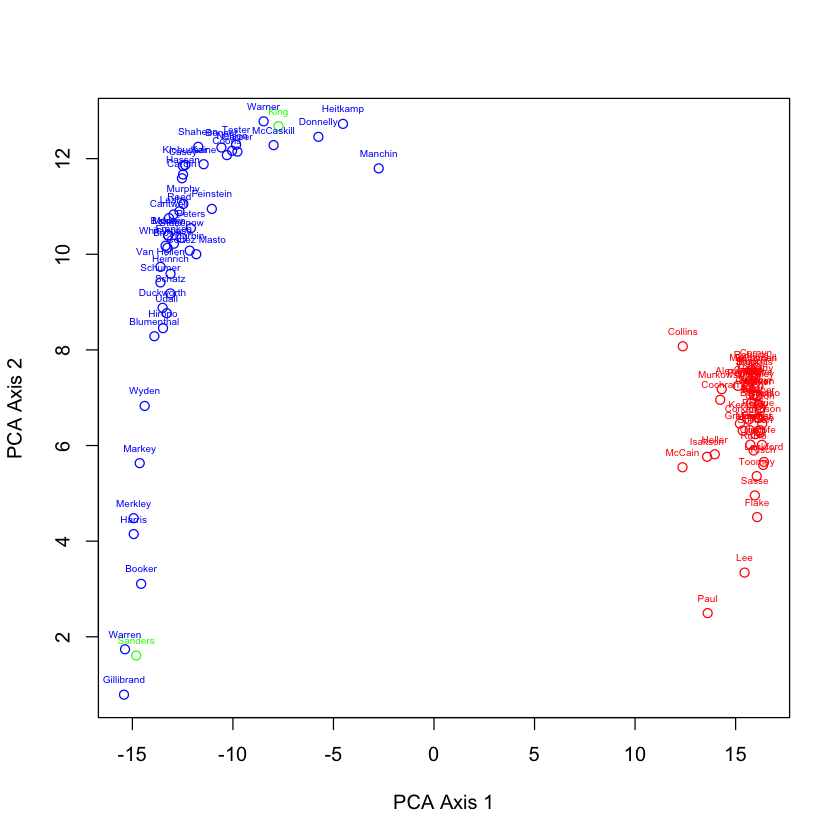

In [63]:
pca_plot(pca_data)

## 2009 Analysis

In [59]:
pca_data <- pca(data_formatting(2009)[[1]], data_formatting(2009)[[2]])

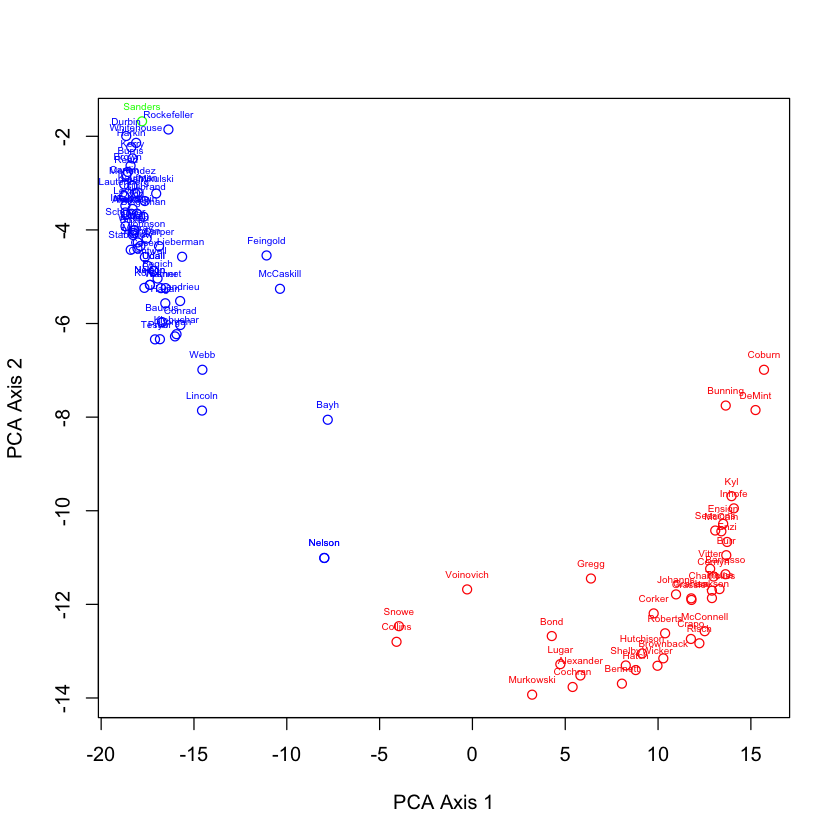

In [60]:
pca_plot(pca_data)